In [1]:
import os
from pathlib import Path
import glob
from datetime import datetime

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

from fastai.vision import *
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
from utils_ import *
import utils_
from io_ import *
from data_ import *
from transforms import *
from models import *
from training import *
from visualizations import *
from monitoring import *
%reload_ext autoreload
%autoreload 2

In [4]:
CLASS_NAMES = ['building', 'tree', 'low-vegetation', 'clutter', 'car', 'pavement']
NCLASSES = len(CLASS_NAMES)

In [5]:
S3_BUCKET = 'raster-vision-ahassan'
S3_ROOT = f'potsdam/experiments/output'

In [6]:
io_handler = S3IoHandler(
    local_root='tmp', 
    s3_bucket=S3_BUCKET, 
    s3_root=S3_ROOT
)

In [75]:
# for i in range(NCLASSES):
#     p, r = logs[f'class_{i}_precision'], logs[f'class_{i}_recall']
#     f1, f2 = utils_.fbeta(p,r, 1), utils_.fbeta(p,r, 2)
#     print('%-15s' % CLASS_NAMES[i], '%2d' % np.argmax(f1), np.max(f1))
#     print('%-15s' % CLASS_NAMES[i], '%2d' % np.argmax(f2), np.max(f2))

In [46]:
name = 'ss_rgb_deeplab_resnet101p'
logs = io_handler.load_pickled_file(s3_path=f'{S3_ROOT}/{name}/logs.pkl', tgt_path=f'logs_{name}', force_download=False)
logs = {k: np.array(v) for k, v in logs.items()}

In [37]:
p = np.concatenate([logs[f'class_{i}_precision'][:, None] for i in range(NCLASSES)], axis=-1)
r = np.concatenate([logs[f'class_{i}_recall'][:, None] for i in range(NCLASSES)], axis=-1)
f1, f2 = utils_.fbeta(p,r, 1), utils_.fbeta(p,r, 2)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0

In [15]:
idx = np.argmax(f1.mean(axis=-1))
for i in range(NCLASSES):
    print('%s, %s, %d, %s, %f, %f' % ('deeplab', 'RGBE', 1, CLASS_NAMES[i], p[idx, i], r[idx, i]))

deeplab, RGBE, 1, building, 0.966737, 0.973376
deeplab, RGBE, 1, tree, 0.881496, 0.844353
deeplab, RGBE, 1, low-vegetation, 0.838214, 0.853859
deeplab, RGBE, 1, clutter, 0.782022, 0.532222
deeplab, RGBE, 1, car, 0.906052, 0.887598
deeplab, RGBE, 1, pavement, 0.879493, 0.923765


In [163]:
# idx = np.argmax(f1.mean(axis=-1))
# print(idx)
# # print('precision')
# print(','.join(map(str, p[idx])))
# # print('recall')
# print(','.join(map(str, r[idx])))
# # print('f1')
# # print(f1[idx])
# # print('f2')
# # print(f2[idx])

77
0.9509671926498413,0.8361125588417053,0.793807864189148,0.742587685585022,0.8820816874504089,0.8612779974937439
0.9544430375099182,0.7996278405189514,0.820135235786438,0.4991568326950073,0.8787941336631775,0.9010058045387268


In [153]:
import tabulate
print(tabulate.tabulate(f1.mean(axis=-1)[idx:idx+2, None], tablefmt='grid'))

+----------+
| 0.592279 |
+----------+
| 0.54148  |
+----------+


In [45]:
logs_nopt = logs

In [64]:
ptacc = np.zeros((100,))
ptacc[:40] = logs['val_acc']
ptacc[40:] = max(logs['val_acc'])
ptacc.shape

(100,)

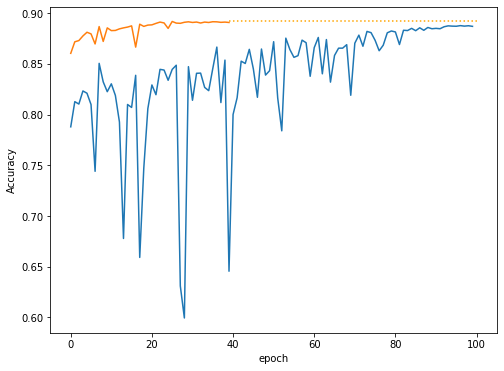

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(logs1['epoch'], logs1['val_acc'])
plt.plot(logs['epoch'], logs['val_acc'])
plt.hlines(max(logs['val_acc']), xmin=40-1, xmax=100, ls=':', color='orange')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()